In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import json

from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import time
from datetime import datetime
import os
from torch.utils import data
import random
import copy
import itertools
import io
import uuid
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import umap
import hdbscan
import warnings
warnings.filterwarnings('ignore')

#import wandb
#wandb_username = 'denizjafari'
local_username = 'denizjafari'

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0') 
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [3]:
# root directory
root_dir = "/home/andreasabo/Documents/HNProject/"
split_file_base = "/home/denizjafari/Documents/HNProject/HNUltra/"

# data directory on current machine: abhishekmoturu, andreasabo, denizjafari, navidkorhani
data_dir = "/home/" + local_username + "/Documents/HNProject/all_label_img/"

# read target df
csv_path = os.path.join(root_dir, "all_splits_1000000.csv")
data_df = pd.read_csv(csv_path, usecols=['subj_id', 'image_ids', 'view_label', 'view_train'])

In [4]:
data_df.head()

,image_ids,view_label,subj_id,view_train
0,1323_2_1,Missing,1323,NaN
1,1323_2_2,Missing,1323,NaN
2,1323_2_3,Missing,1323,NaN
3,1323_2_4,Missing,1323,NaN
4,1323_2_5,Missing,1323,NaN


### **Reading Data Indicies and Labels**

In [5]:
label_mapping = {'Other':0, 'Saggital_Right':1, 'Transverse_Right':2, 
                 'Saggital_Left':3, 'Transverse_Left':4, 'Bladder':5}
label_unmapping = {0: 'Other', 1:'Saggital_Right', 2: 'Transverse_Right', 
                   3:'Saggital_Left', 4:'Transverse_Left', 5: 'Bladder'}

data_df['view_label'] = data_df['view_label'].map(label_mapping)

train_df = data_df[data_df.view_train == 1]
test_df = data_df[data_df.view_train == 0]

unique_subj = train_df.subj_id.unique()

# Create the splits for 5-fold cross validation based on subj_id
data_split_file = split_file_base + 'data_splits.json'
if not os.path.isfile(data_split_file):

    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    fold = 0
    all_folds = {}
    for train_subj, val_subj in kf.split(unique_subj):
        train_ids  = unique_subj[train_subj]
        val_ids = unique_subj[val_subj]

        train_images = train_df[train_df.subj_id.isin(train_ids)].image_ids.tolist()
        val_images = train_df[train_df.subj_id.isin(val_ids)].image_ids.tolist()
        train_labels = train_df[train_df.subj_id.isin(train_ids)].view_label.tolist()
        val_labels = train_df[train_df.subj_id.isin(val_ids)].view_label.tolist()
        cur_fold = {'train_ids': train_images, 'valid_ids': val_images, 'train_labels': train_labels, 'valid_labels': val_labels}
        all_folds[fold] = cur_fold
        fold += 1

    print("Saving data splits")
    with open(data_split_file, 'w') as f:
        json.dump(all_folds, f)

else: # just load from file
    print("Reading splits from file")
    with open(data_split_file, 'r') as f:
        all_folds = json.load(f)
        

# just use one folds for now 
partition = all_folds['0']

Reading splits from file


In [6]:
def set_parameter_requires_grad(model, feature_extracting):
    ct = 0 
    if feature_extracting:
        for child in model.children():
            ct +=1
            if ct <8:
                for param in child.parameters():
                    param.requires_grad = False

In [7]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        model_ft.fc = nn.Sequential( nn.Linear(num_ftrs, 60), nn.Linear(60, num_classes) ) 
        input_size = 256

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name == 'viewnet':
        conv1_filters = 8
        conv2_filters = 16
        conv3_filters = 32
        linear1_size = 512
        dropout = 0.25
        model_ft = ViewNet(num_classes, conv1_filters, conv2_filters, conv3_filters, linear1_size, dropout)
        input_size = 256
        
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, writer = None):
    since = time.time()
    classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 54)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            running_preds = []
            running_labels = []

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                labels = labels.type(torch.long)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        labels = torch.argmax(labels, 1)
                        running_preds += torch.argmax(outputs, 1).tolist()
                        running_labels += labels.tolist()
                        loss = criterion(outputs, labels)

                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} loss:\t{:.4f} | {} acc:\t{:.4f}\n'.format(phase, epoch_loss, phase, epoch_acc))
            # Log to tensorboard for visualization
            if writer is not None and phase == 'train':
                writer.add_scalar('Loss/train', epoch_loss, epoch)
                writer.add_scalar('Accuracy/train', epoch_acc, epoch)
#                 cm = confusion_matrix(running_labels, running_preds)
#                 figure = plot_confusion_matrix_local(cm, classnames)
#                 writer.add_image('confusion_matrix/train', figure, epoch)
                
                
                
            if writer is not None and phase == 'val':
                writer.add_scalar('Loss/val', epoch_loss, epoch)
                writer.add_scalar('Accuracy/val', epoch_acc, epoch)
                
#                 cm = confusion_matrix(running_labels, running_preds)
#                 figure = plot_confusion_matrix_local(cm, classnames)
#                 writer.add_image('confusion_matrix/val', figure, epoch)
            # deep copy the model
            if phase == 'train':
                print(classification_report(running_labels, running_preds))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(classification_report(running_labels, running_preds))
            if phase == 'val':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [9]:
if 0:
    def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
        since = time.time()
        classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
        val_acc_history = []

        val_metrics_list = []
        train_metrics_list = []

        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        epoch_with_best_val_acc = 0
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 54)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                running_preds = []
                running_labels = []

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    labels = labels.type(torch.long)
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        # Special case for inception because in training it has an auxiliary output. In train
                        #   mode we calculate the loss by summing the final output and the auxiliary output
                        #   but in testing we only consider the final output.
                        if is_inception and phase == 'train':
                            # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                            outputs, aux_outputs = model(inputs)
                            loss1 = criterion(outputs, labels)
                            loss2 = criterion(aux_outputs, labels)
                            loss = loss1 + 0.4*loss2
                        else:
                            outputs = model(inputs)
                            labels = torch.argmax(labels, 1)
                            running_preds += torch.argmax(outputs, 1).tolist()
                            running_labels += labels.tolist()
                            loss = criterion(outputs, labels)

                        preds = torch.argmax(outputs, 1)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(dataloaders[phase].dataset)
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                print('{} loss:\t{:.4f} | {} acc:\t{:.4f}\n'.format(phase, epoch_loss, phase, epoch_acc))

                if phase == 'train':
                    wandb.log({'epoch': epoch, 'train_loss':epoch_loss})
                    wandb.log({'epoch': epoch, 'train_acc':epoch_acc})

                    cur_train_metrics = {}
                                    # compute and log f1, precision, recall for each class
                    for c in range(6):
                        running_labels = np.asarray(running_labels)
                        running_preds = np.asarray(running_preds)

                        cur_c_labs_bin = np.asarray([0] *len(running_labels))
                        cur_c_preds_bin = np.asarray([0] *len(running_labels))

                        # Need to binarize
                        cur_c_preds_bin[running_preds == c] = 1
                        cur_c_labs_bin[running_labels == c] = 1
                        f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
                        precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
                        recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)

                        cur_train_metrics['train_' + label_unmapping[c] + '_f1'] = f1
                        cur_train_metrics['train_' + label_unmapping[c] + '_precision'] = precision
                        cur_train_metrics['train_' + label_unmapping[c] + '_recall'] = recall


                    train_metrics_list.append(cur_train_metrics)



                if phase == 'val':
                    wandb.log({'epoch': epoch, 'valid_loss':epoch_loss})
                    wandb.log({'epoch': epoch, 'valid_acc':epoch_acc})


                    cur_val_metrics = {}
                    # compute and log f1, precision, recall for each class
                    for c in range(6):
                        running_labels = np.asarray(running_labels)
                        running_preds = np.asarray(running_preds)

                        cur_c_labs_bin = np.asarray([0] *len(running_labels))
                        cur_c_preds_bin = np.asarray([0] *len(running_labels))

                        # Need to binarize
                        cur_c_preds_bin[running_preds == c] = 1
                        cur_c_labs_bin[running_labels == c] = 1
                        f1 = f1_score(cur_c_labs_bin, cur_c_preds_bin)
                        precision = precision_score(cur_c_labs_bin, cur_c_preds_bin)
                        recall = recall_score(cur_c_labs_bin, cur_c_preds_bin)
                        wandb.log({'epoch': epoch, 'valid_' + label_unmapping[c] + '_f1': f1})
                        wandb.log({'epoch': epoch, 'valid_' + label_unmapping[c] + '_precision': precision})
                        wandb.log({'epoch': epoch, 'valid_' + label_unmapping[c] + '_recall': recall})

                        cur_val_metrics['val_' + label_unmapping[c] + '_f1'] = f1
                        cur_val_metrics['val_' + label_unmapping[c] + '_precision'] = precision
                        cur_val_metrics['val_' + label_unmapping[c] + '_recall'] = recall

                    val_metrics_list.append(cur_val_metrics)

                if phase == 'train':
                    print(classification_report(running_labels, running_preds))
                    train_acc = epoch_acc
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_acc_train = train_acc
                    epoch_with_best_val_acc = epoch
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), os.path.join(wandb.run.dir, "model.pt"))
                    print(classification_report(running_labels, running_preds))
                if phase == 'val':
                    val_acc_history.append(epoch_acc)

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val acc: {:4f}\n'.format(best_acc))

        # Directly save the best results in this fold
        wandb.config.best_acc = best_acc
        wandb.config.val_acc_history = val_acc_history
        wandb.config.best_epoch = epoch_with_best_val_acc

        wandb.config.update(val_metrics_list[epoch_with_best_val_acc])
        wandb.config.update(train_metrics_list[epoch_with_best_val_acc])

        metrics_from_best_epoch = {'best_epoch': epoch_with_best_val_acc}
        metrics_from_best_epoch.update( val_metrics_list[epoch_with_best_val_acc] )
        metrics_from_best_epoch.update( train_metrics_list[epoch_with_best_val_acc] )
        metrics_from_best_epoch.update( {'val_acc': best_acc, 'train_acc': best_acc_train} )    
        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, val_acc_history, metrics_from_best_epoch

DATA Loading

In [10]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception, viewnet]
model_name = "resnet"

# Number of classes in the dataset: right_sag, right_trav, left_sag, left_trav, bladder, other
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 100

# Number of epochs to train for
num_epochs = 20

# Flag for feature extracting. When False, we finetune the whole model; when True we only update the reshaped layer params
feature_extract = True

# Flag for whether or not to use pretrained model
pretrain = True

In [11]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract=feature_extract, use_pretrained=True)
#print(model_ft)

running the model

In [12]:
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4, weight_decay=0, amsgrad=True) # lr=1e-4, weight_decay=0, amsgrad=False

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.0.weight
	 fc.0.bias
	 fc.1.weight
	 fc.1.bias


In [13]:
# Data augmentation and normalization for training
class Dataset(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img_path = data_dir + ID + '.jpg'
        image = Image.open(img_path)#.convert('L')
        image = ToTensor()(image)
        y = torch.FloatTensor([0]*6)
       
        y[int(self.labels[index])] = 1

        return image, y
# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 6}

# Generators
training_set = Dataset(partition['train_ids'], partition['train_labels'])
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['valid_ids'], partition['valid_labels'])
validation_generator = data.DataLoader(validation_set, **params)

dataloaders_dict = {'train':training_generator, 'val':validation_generator}

In [14]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, 25, is_inception=(model_name=="inception"))

Epoch 1/25
------------------------------------------------------
train loss:	1.1218 | train acc:	0.5792

              precision    recall  f1-score   support

           0       0.58      0.81      0.68      3724
           1       0.58      0.44      0.50      1813
           2       0.62      0.22      0.32      1218
           3       0.51      0.56      0.53      1895
           4       0.50      0.37      0.43      1359
           5       0.77      0.73      0.75      1072

    accuracy                           0.58     11081
   macro avg       0.59      0.52      0.53     11081
weighted avg       0.58      0.58      0.56     11081

val loss:	1.1983 | val acc:	0.5523

              precision    recall  f1-score   support

           0       0.69      0.51      0.59      1219
           1       0.66      0.57      0.61       412
           2       0.52      0.45      0.48       321
           3       0.39      0.65      0.49       389
           4       0.37      0.48      0.42 

val loss:	1.9275 | val acc:	0.5572

Epoch 10/25
------------------------------------------------------
train loss:	0.0065 | train acc:	0.9982

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3724
           1       1.00      1.00      1.00      1813
           2       1.00      1.00      1.00      1218
           3       1.00      1.00      1.00      1895
           4       1.00      1.00      1.00      1359
           5       1.00      1.00      1.00      1072

    accuracy                           1.00     11081
   macro avg       1.00      1.00      1.00     11081
weighted avg       1.00      1.00      1.00     11081

val loss:	1.9283 | val acc:	0.5607

Epoch 11/25
------------------------------------------------------
train loss:	0.0055 | train acc:	0.9981

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3724
           1       1.00      1.00      1.00      1813
        

val loss:	2.1215 | val acc:	0.5537

Epoch 22/25
------------------------------------------------------
train loss:	0.0032 | train acc:	0.9981

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3724
           1       1.00      1.00      1.00      1813
           2       1.00      1.00      1.00      1218
           3       1.00      1.00      1.00      1895
           4       1.00      1.00      1.00      1359
           5       1.00      1.00      1.00      1072

    accuracy                           1.00     11081
   macro avg       1.00      1.00      1.00     11081
weighted avg       1.00      1.00      1.00     11081

val loss:	2.1722 | val acc:	0.5530

Epoch 23/25
------------------------------------------------------
train loss:	0.0029 | train acc:	0.9984

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3724
           1       1.00      1.00      1.00      1813
        

In [15]:
from sklearn.cluster import KMeans
    
class I(nn.Module):
    def __init__(self):
        super(I, self).__init__()
    def forward(self, x):
        return x

model = model_ft
model = model.to(device)
print(model.fc)
model.fc[1] = I()

# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 6}

# Generators
training_set = Dataset(partition['train_ids'], partition['train_labels'])
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['valid_ids'], partition['valid_labels'])
validation_generator = data.DataLoader(validation_set, **params)

dataloaders = {'train':training_generator, 'val':validation_generator}


Sequential(
  (0): Linear(in_features=512, out_features=60, bias=True)
  (1): Linear(in_features=60, out_features=6, bias=True)
)


In [16]:
classnames = ['Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder']
features_train = []
features_val = []
#label_predictions = []
for image, label in dataloaders['train']:
    features_train.append(np.squeeze(model(image.to(device)).tolist()))
    #label_predictions.append(torch.argmax(label, 1)[0].item())
    
for image, label in dataloaders['val']:
    features_val.append(np.squeeze(model(image.to(device)).tolist()))
    #labels__predictions.append(torch.argmax(label, 1)[0].item())
    

print(len(features_train))
print(len(features_val))
print(features_train[-1].shape)
print(features_val[-1].shape)


11081
2877
(60,)
(60,)


# CLUSTERING DATA


In [17]:
# DATA 


y_train = partition['train_labels']

y_val = partition['valid_labels']

print(len(partition['train_labels']))
print(len(y_train))
print(y_train[0])

print(len(partition['valid_labels']))
print(len(y_val))
print(y_val[0])


print(len(features_train))
print(features_train[0].shape)

print(len(features_val))
print(features_val[0].shape)

11081
11081
0.0
2877
2877
1.0
11081
(60,)
2877
(60,)


# K-Means

In [18]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(features_train)
# kmeans_labels = KMeans(n_clusters=6).fit_predict(features_train)

print(v_measure_score(y_train, kmeans.labels_))

print(adjusted_rand_score(y_train, kmeans.labels_),
    adjusted_mutual_info_score(y_train, kmeans.labels_))

0.0009541701034088125


0.0010205909846150594 0.0002864049296050431


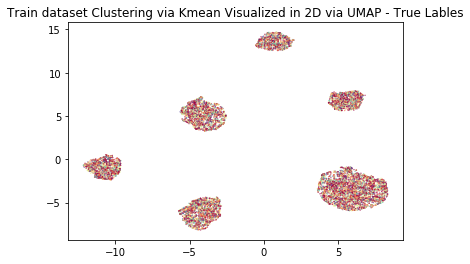

In [21]:
# KMENA visualized in 2D via UMAP 

# THE TRUE LABLES 
standard_embedding = umap.UMAP(random_state=42).fit_transform(features_train)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=y_train, s=0.1, cmap='Spectral')
plt.title('Train dataset Clustering via Kmean Visualized in 2D via UMAP - True Lables');

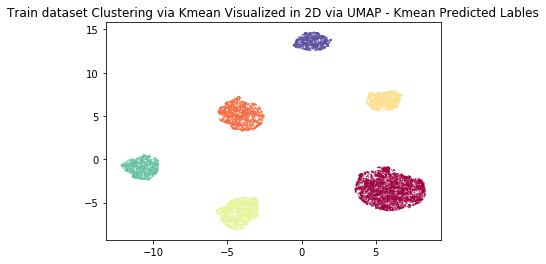

In [22]:
# the lables predicted by kmeans 
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans.labels_, s=0.1, cmap='Spectral');
plt.title('Train dataset Clustering via Kmean Visualized in 2D via UMAP - Kmean Predicted Lables');

# UMAP CLUSTERING 

supervised clstering by fitting the data to the train y and then testing it on val data

In [23]:
embedding = umap.UMAP(n_neighbors=50, min_dist=0.0, metric = "manhattan",
                                  n_components=2,random_state=42).fit(features_train)


In [24]:
mapper = umap.UMAP(n_neighbors=50, min_dist=0.0, metric = "manhattan",
                                  n_components=2,random_state=42).fit(features_train, y=y_train)

In [25]:
val_embedding = mapper.transform(features_val)

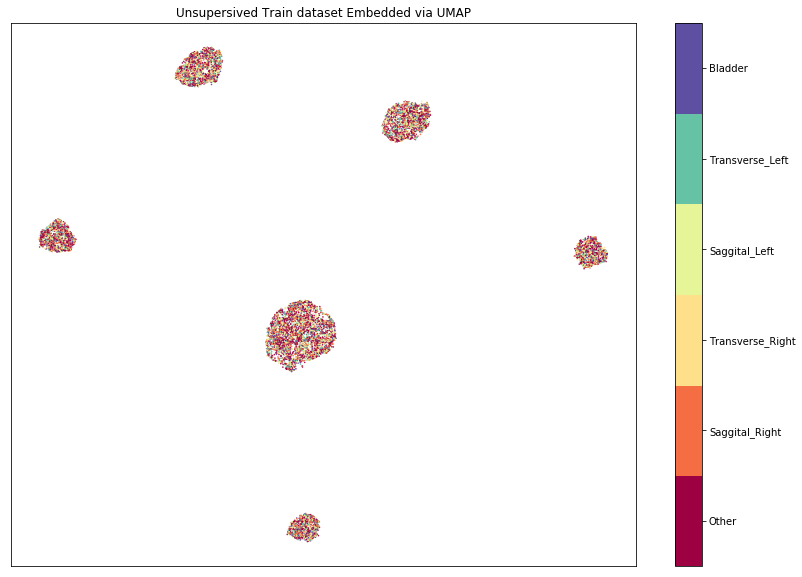

In [26]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.embedding_.T, s=0.3, c=y_train, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Unsupersived Train dataset Embedded via UMAP');


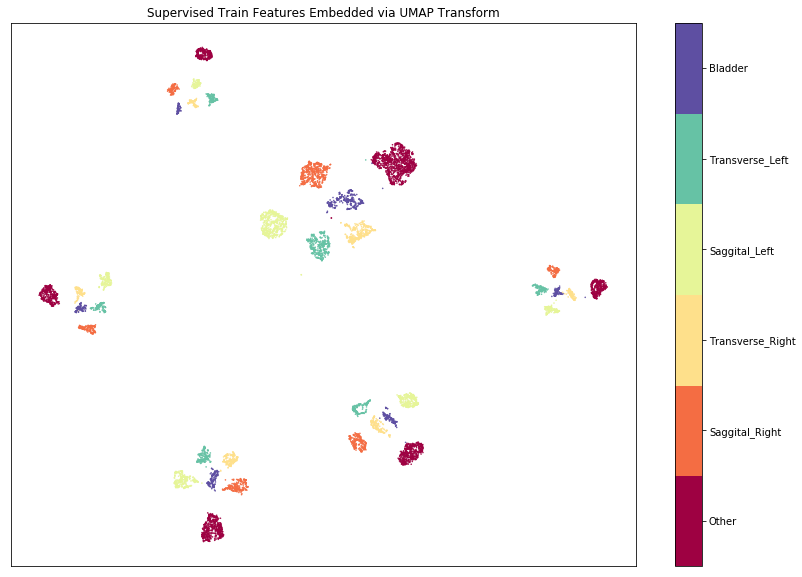

In [27]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*mapper.embedding_.T, s=0.3, c=np.array(y_train), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Supervised Train Features Embedded via UMAP Transform');

In [28]:
len(features_val)

2877

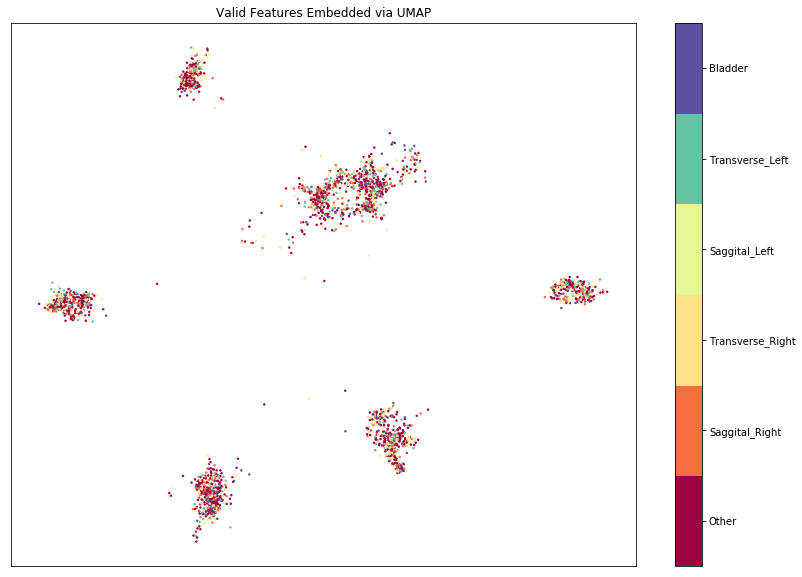

In [29]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*val_embedding.T, s=2, c=np.array(y_val), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Valid Features Embedded via UMAP');

# Seeing How KNN and SVN Behave 

In [30]:
svc = SVC().fit(features_train, y_train)
knn = KNeighborsClassifier().fit(features_train, y_train)

In [31]:
print(svc.score(features_val, y_val), knn.score(features_val, y_val))

#print(adjusted_rand_score(y_train, kmeans.labels_),
#    adjusted_mutual_info_score(y_train, kmeans.labels_))

0.42370524852276675 0.29579423010079947


In [32]:
umap_helper = umap.UMAP(n_neighbors=50,  metric = "manhattan",
                                  n_components=2,random_state=42).fit(features_train)

In [33]:
svc = SVC().fit(umap_helper.embedding_, y_train)
knn = KNeighborsClassifier().fit(umap_helper.embedding_, y_train)

In [34]:
print(svc.score(umap_helper.transform(features_val), y_val),
      knn.score(umap_helper.transform(features_val), y_val))

0.42370524852276675 0.29927007299270075


# TSNE 

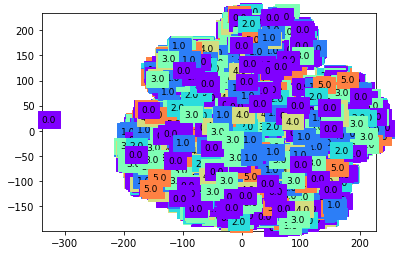

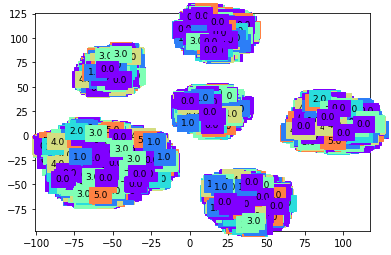

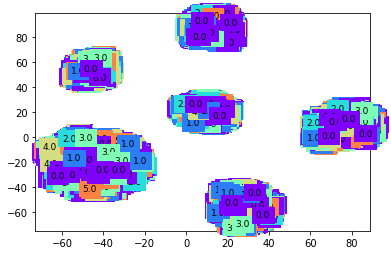

In [35]:
# Plot tsne clustering based on fine-tuned resnet18 outputs, with labels of correct answer
from matplotlib import cm
from sklearn.manifold import TSNE

def plot_with_labels(lowDWeights, labels):
    #plt.cla() # Clear current axis
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 6)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()) 
    plt.ylim(Y.min(), Y.max())
    plt.show()

    
preplexity = [5, 50, 100]

for p in preplexity:
    tsne = TSNE(perplexity=p, n_components=2, init='pca', n_iter=5000)
    low_dim_embs = tsne.fit_transform(features_train)
    plot_with_labels(low_dim_embs, y_train)


# VAE (Navid's encoder)


In [36]:
class VAE_50(nn.Module):
    def __init__(self):
        super(VAE_50, self).__init__()
        
        hidden_dim = 800
        latent_dim = 50
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    
class VAE_100(nn.Module):
    def __init__(self):
        super(VAE_100, self).__init__()
        
        hidden_dim = 800
        latent_dim = 100
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
class VAE_200(nn.Module):
    def __init__(self):
        super(VAE_200, self).__init__()
        
        hidden_dim = 800
        latent_dim = 200
        self.fc1 = nn.Linear(65536, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)
        self.fc22 = nn.Linear(hidden_dim, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 65536)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        #print("z.size() =", z.size())
        h3 = F.relu(self.fc3(z))
        #print("h3.size() =", h3.size())
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 65536))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [37]:
vae50_dir = '/home/navidkorhani/Documents/HNProject/HNUltra/saved models/vae_model_h800_l50.pt'
vae100_dir = "/home/navidkorhani/Documents/HNProject/HNUltra/results/h800_l100_e30/vae_model.pt"
vae200_dir = "/home/navidkorhani/Documents/HNProject/HNUltra/results/h800_l200_e30/vae_model.pt"

model_50 = VAE_50()
checkpoint = torch.load(vae50_dir)
model_50.load_state_dict(checkpoint)

model_100 = VAE_100()
checkpoint = torch.load(vae100_dir)
model_100.load_state_dict(checkpoint)

model_200 = VAE_200()
checkpoint = torch.load(vae200_dir)
model_200.load_state_dict(checkpoint)

<All keys matched successfully>

In [38]:
class Dataset_2(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        img_path = data_dir + ID + '.jpg'
        image = Image.open(img_path).convert('L')
        image = ToTensor()(image)
        y = torch.FloatTensor([0]*6)
       
        y[int(self.labels[index])] = 1

        return image, y
# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 6}

# Generators
training_set = Dataset_2(partition['train_ids'], partition['train_labels'])

In [50]:
validation_set = Dataset_2(partition['valid_ids'], partition['valid_labels'])

In [51]:
# change this such that I can read the labels as well 

z_all_50 = []
z_all_100 = []
z_all_200 = []
#z_labels = []
for  image, label in training_set:
    #z_labels.append(label)
    mu, logvar = model_50.encode(image.view(-1, 65536))
    z = model_50.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_50.append(z)
    mu, logvar = model_100.encode(image.view(-1, 65536))
    z = model_100.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_100.append(z)
    mu, logvar = model_200.encode(image.view(-1, 65536))
    z = model_200.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_200.append(z)


In [52]:
z_all_50_v = []
z_all_100_v = []
z_all_200_v = []
for  image, label in validation_set:
    #z_labels.append(label)
    mu, logvar = model_50.encode(image.view(-1, 65536))
    z = model_50.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_50_v.append(z)
    mu, logvar = model_100.encode(image.view(-1, 65536))
    z = model_100.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_100_v.append(z)
    mu, logvar = model_200.encode(image.view(-1, 65536))
    z = model_200.reparameterize(mu, logvar)
    z = z.detach().numpy()
    z_all_200_v.append(z)


In [57]:
print(len(z_all_50))
print(len(z_all_100))
print(len(z_all_200))
print(len(y_train))
print(len(z_all_50_v))
print(len(z_all_100_v))
print(len(y_val))

11081
11081
11081
11081
2877
2877
2877


In [53]:
z_all_50 = [z.reshape(-1,) for z in z_all_50]
z_all_100 = [z.reshape(-1,) for z in z_all_100]
z_all_200 = [z.reshape(-1,) for z in z_all_200]

z_all_50_v = [z.reshape(-1,) for z in z_all_50_v]
z_all_100_v = [z.reshape(-1,) for z in z_all_100_v]
z_all_200_v = [z.reshape(-1,) for z in z_all_200_v]

In [56]:
print(z_all_50[0].shape)
print(z_all_50_v[0].shape)


(50,)
(50,)


In [58]:
# KNN and SVC on VAE


svc_50 = SVC().fit(z_all_50, y_train)
knn_50 = KNeighborsClassifier().fit(z_all_50, y_train)
print(svc_50.score(z_all_50_v, y_val), knn_50.score(z_all_50_v, y_val))

svc_100 = SVC().fit(z_all_100, y_train)
knn_100 = KNeighborsClassifier().fit(z_all_100, y_train)
print(svc_100.score(z_all_100_v, y_val), knn_100.score(z_all_100_v, y_val))

svc_200 = SVC().fit(z_all_200, y_train)
knn_200 = KNeighborsClassifier().fit(z_all_200, y_train)
print(svc_200.score(z_all_200_v, y_val), knn_200.score(z_all_200_v, y_val))

0.47584289190128604 0.4045881126173097
0.47792839763642686 0.3684393465415363
0.46958637469586373 0.35384080639555093


In [60]:
# KMEANS on VAE

# training
kmeans_50 = KMeans(n_clusters=6, random_state=0).fit(z_all_50)
kmeans_100 = KMeans(n_clusters=6, random_state=0).fit(z_all_100)
kmeans_200 = KMeans(n_clusters=6, random_state=0).fit(z_all_200)
# kmeans_labels = KMeans(n_clusters=6).fit_predict(features_train)

print(v_measure_score(y_train, kmeans_50.labels_))
print(adjusted_rand_score(y_train, kmeans_50.labels_), adjusted_mutual_info_score(y_train, kmeans_50.labels_))

print(v_measure_score(y_train, kmeans_100.labels_))
print(adjusted_rand_score(y_train, kmeans_100.labels_), adjusted_mutual_info_score(y_train, kmeans_100.labels_))

print(v_measure_score(y_train, kmeans_200.labels_))
print(adjusted_rand_score(y_train, kmeans_200.labels_), adjusted_mutual_info_score(y_train, kmeans_200.labels_))

0.04526009790687894
0.026062726964550705 0.04463958593079661
0.056935171930297235
0.038882545397599236 0.05632196157397873
0.057654137017189216
0.0378222173932527 0.057040961707500115


In [63]:
# validation 
l_50 = kmeans_50.predict(z_all_50_v)
print(v_measure_score(y_val, l_50))

l_100 = kmeans_100.predict(z_all_100_v)
print(v_measure_score(y_val, l_100))

l_200 = kmeans_200.predict(z_all_200_v)
print(v_measure_score(y_val, l_200))

0.03342691723917611
0.03509659889068288
0.03706444188786042


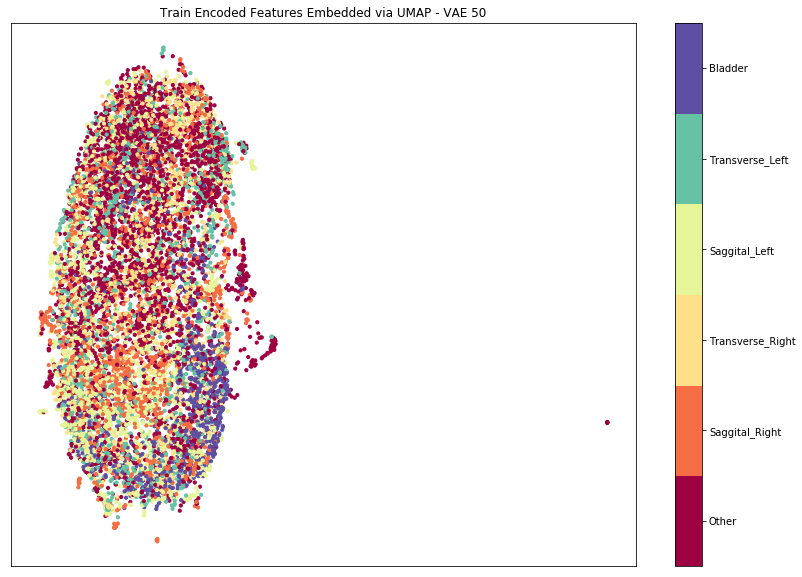

In [64]:
# UMAP CLUSTERING FOR 50 FEATURES 


clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit_transform(z_all_50)



fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=10, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP - VAE 50');


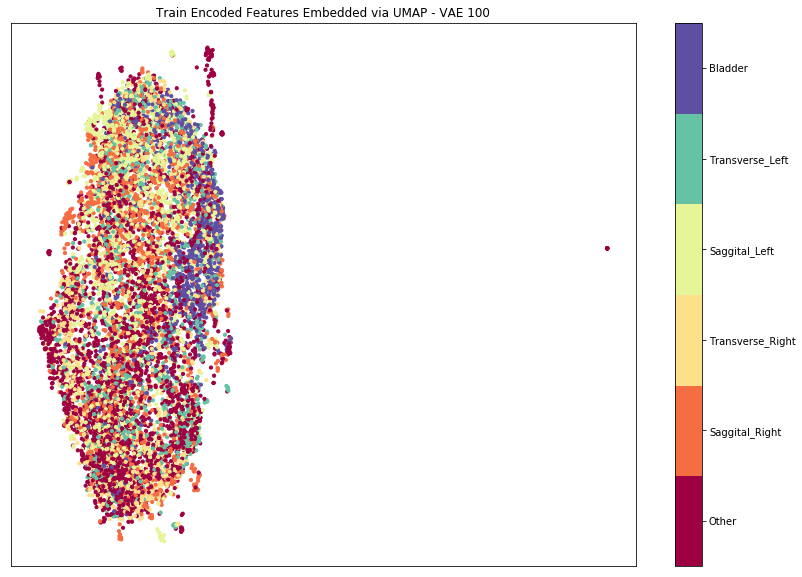

In [65]:
# UMAP CLUSTERING FOR 100 FEATURES 

clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit_transform(z_all_100)



fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=10, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP - VAE 100');

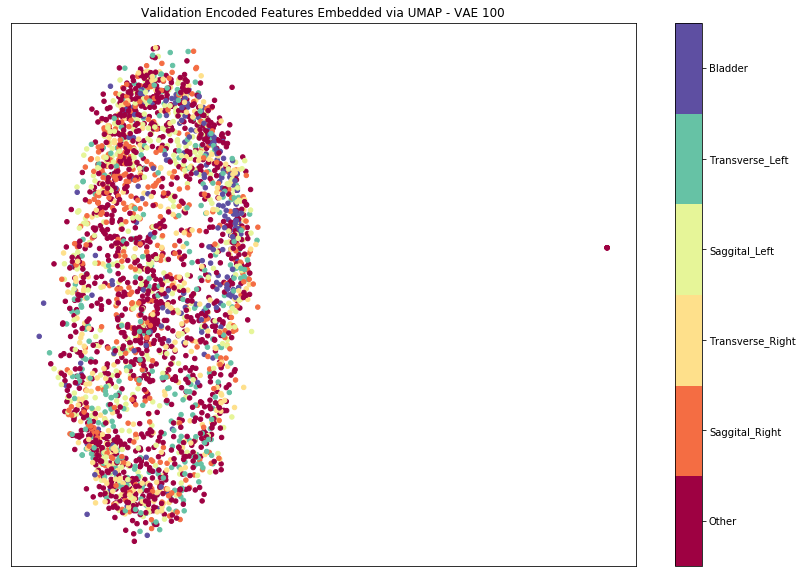

In [68]:

clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit(z_all_100)

val_embedding = clusterable_embedding.transform(z_all_100_v)


fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(val_embedding[:, 0], val_embedding[:, 1], c=y_val, s=20, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Validation Encoded Features Embedded via UMAP - VAE 100');

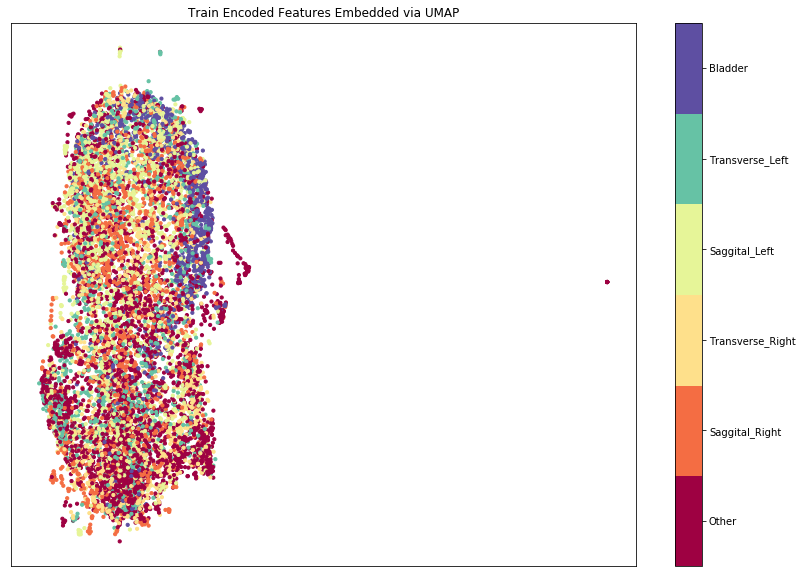

In [43]:

clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit_transform(z_all_200)


fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=10, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP - VAE 200');

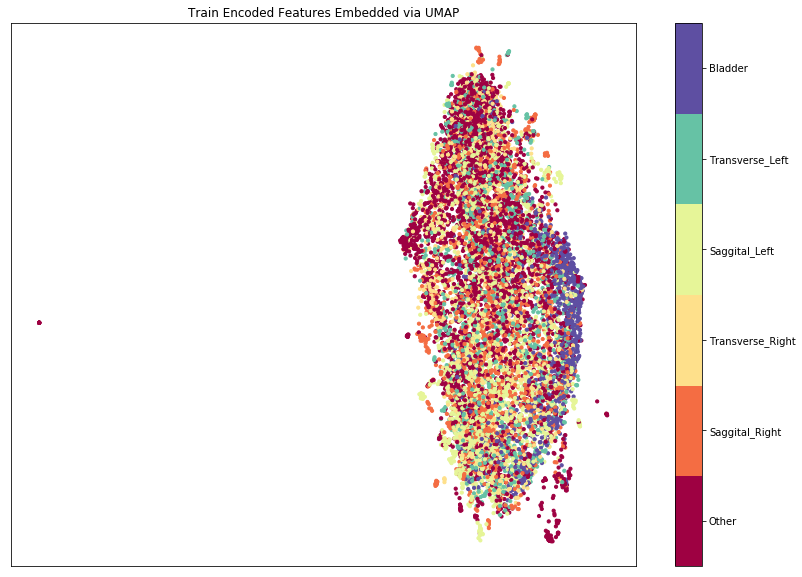

In [44]:
clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit_transform(z_all_200)

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=10, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP');

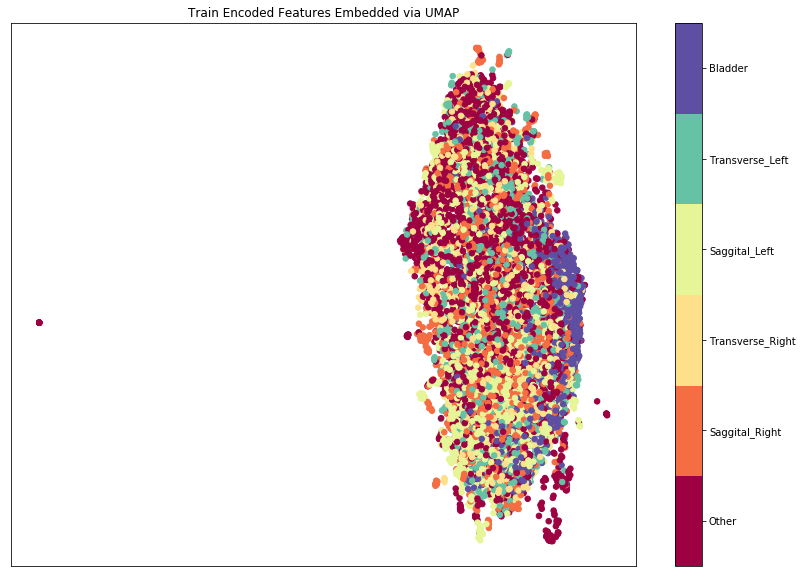

In [45]:
# 100 latent variables 

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=30, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP');

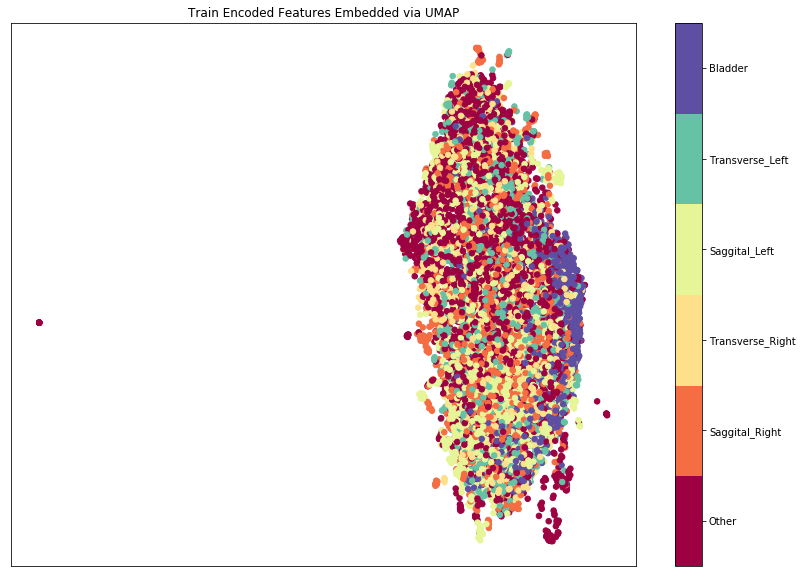

In [46]:
# 100 latent variables 


fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], c=y_train, s=30, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP');

In [ ]:
# METHOD 2 OF VISUALZING THE ABOVE RESULTS
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*clusterable_embedding.embedding_.T, c=y_train, s=0.1, cmap='Spectral')
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(7)-0.5)
cbar.set_ticks(np.arange(6))
cbar.set_ticklabels(classnames)
plt.title('Train Encoded Features Embedded via UMAP');

# HDBSCAN

In [48]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')
clusterer.fit(features_train)
print(clusterer.labels_.max())

clusterer.labels_

6


array([1, 6, 0, ..., 6, 1, 2])

In [ ]:
clusterable_embedding.shape

In [ ]:
classnames_2 = ['noise','Other', 'Saggital_Right', 'Transverse_Right', 'Saggital_Left','Transverse_Left', 'Bladder', 'unknown']

fig, ax = plt.subplots(1, figsize=(14, 10))
color_palette = sns.color_palette('deep', 20)
cluster_colors = [color_palette[x] if x >= 0
              else (0.5, 0.5, 0.5)
              for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                     zip(cluster_colors, clusterer.probabilities_)]

plt.scatter(*clusterable_embedding.embedding_.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)
cbar = plt.colorbar(boundaries=np.arange(9)-0.5)
cbar.set_ticks(np.arange(8))
cbar.set_ticklabels(classnames_2)



In [49]:
clusterer_z = hdbscan.HDBSCAN(metric='manhattan')
clusterer_z.fit(z_all_100)
print(clusterer_z.labels_.max())

49


In [ ]:
fig, ax = plt.subplots(1, figsize=(14, 10))

color_palette = sns.color_palette('deep', 40)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer_z.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer_z.probabilities_)]
plt.scatter(*clusterable_embedding.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)

cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classnames_2)


In [ ]:
clusterable_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,metric = "manhattan",
                                  n_components=2,random_state=42).fit_transform(features_train)

labels_hdbscan = hdbscan.HDBSCAN(
    min_samples=10, min_cluster_size=500).fit_predict(clusterable_embedding)


clustered = (labels_hdbscan >= 0)
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=2,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels_hdbscan[clustered],
            s=2,
            cmap='Spectral');

In [ ]:
labels_hdbscan.max()

In [ ]:
print(v_measure_score(y_train, labels_hdbscan))

In [ ]:
adjusted_rand_score(y_train, labels_hdbscan), adjusted_mutual_info_score(y_train, labels_hdbscan)

In [ ]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec

X= features

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

clust.fit(X)
space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
optics_labels = clust.labels_[clust.ordering_]

plt.figure()

# OPTICS
colors = ['g.', 'r.', 'b.', 'olive','y.', 'c.']
for klass, color in zip(range(0, 6), colors):
    Xk = X[clust.labels_ == klass]
    ax.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax.set_title('Automatic Clustering\nOPTICS')
plt.show()


In [ ]:
optics_labels.max()

In [ ]:
print(len(clust.labels_))
print(X[0])